In [1]:
import swarms
import pread as pd
from numpy import linspace, logspace, pi, array, exp
import matplotlib.pyplot as plt

In [69]:
RHO=1500
M0 = 10 * 7.34767309e22; Dt = 100.; Dmax = 250000.; L_s = 10 * 3.828e26;
M_s = 1.86 * 1.989e30; M_pl = 20 * 1.89587112e27; a_pl = 50 * 1.496e11
R_pl = 6.9911e7; eta = 0.4; Nstr = 6.; d_pl = 10 * 3.086e16
argv = [M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr, d_pl]

In [83]:
t = 1e9
waverange = logspace(-7, -3, 200)
lamb = 1.65e-6
a_plv = linspace(2 * 1.496e11, 80 * 1.496e11, 500)
type_star = "M"

In [84]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [85]:
def Fplt(B_nu_plt, R_plt, d_plt):
    return B_nu_plt * pi * R_plt ** 2 / d_plt ** 2

In [86]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
data = pd.Pread('data', 'Z002', 'pltlum_M20Z002.csv') 

In [87]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

In [100]:
def waverange_plt():
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    fplt_list = []

    s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1./1.2)
    s.updateSwarm(t)
    T_star = s.stellarTemp()
    B_nu = s.computeBmu(waverange, T_star)
    F_star = Fstar(L_s, B_nu, T_star, d_pl)/1e-26

    for i in range(len(waverange)):
        s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                a_pl, R_pl, eta, Nstr, d_pl,
                                rho=RHO, fQ=5, f_vrel=4/pi,
                                correction=True, alpha=1.2)

        s2.updateSwarm(t)

        index = data.find_time_index(t)
        if (index > -1):
            T_plt = lum_to_temp(data.lumin[index], data.radii[index])
            B_nu_plt = s2.computeBmu(waverange[i], T_plt)
            F_plt = Fplt(B_nu_plt, data.radii[index], d_pl)
            fplt_list.append(F_plt/1e-26)

    contrast_rat_plt = array(fplt_list) / F_star
    return contrast_rat_plt

In [101]:
def apl_plt():
    if type_star == "A":
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    fplt_list = []

    s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                        d_pl, correction=True, alpha=1./1.2)
    s.updateSwarm(t)
    T_star = s.stellarTemp()
    B_nu = s.computeBmu(lamb, T_star)
    F_star = Fstar(L_s, B_nu, T_star, d_pl)/1e-26


    for i in range(len(a_plv)):
        s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                a_plv[i], R_pl, eta, Nstr, d_pl,
                                rho=RHO, fQ=5, f_vrel=4/pi,
                                correction=True, alpha=1.2)

        s2.updateSwarm(t)

        index = data.find_time_index(t)
        if (index > -1):
            T_plt = lum_to_temp(data.lumin[index], data.radii[index])
            B_nu_plt = s2.computeBmu(lamb, T_plt)
            F_plt = Fplt(B_nu_plt, data.radii[index], d_pl)
            fplt_list.append(F_plt/1e-26)

    contrast_rat_plt = array(fplt_list) / F_star
    return contrast_rat_plt

In [102]:
contrast_wave_plt = waverange_plt()
contrast_apl_plt = apl_plt()

In [103]:
f_vrel = 4/pi
Qd = s.computeQd(s.Dc)
part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
part2 = (M_pl/5.972e24)**0.06 * Qd**0.15 * eta
part3 = t * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

a_opt = 50 * part1 / part2 * part3**0.24 
print(a_opt)

42.83913147638353


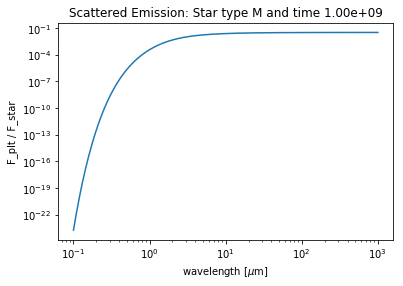

No handles with labels found to put in legend.


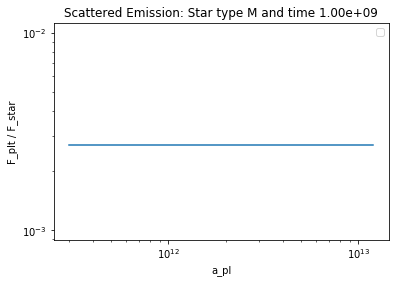

In [106]:
plt.figure(4)
plt.loglog(waverange*1e6, contrast_wave_plt)
plt.title("Scattered Emission: Star type "+str(type_star)+" and time {0:.2e}".format(t))
plt.xlabel(r"wavelength [$\mu$m]")
plt.ylabel("F_plt / F_star")
plt.show()

plt.figure(5)
plt.loglog(a_plv, contrast_apl_plt)
#plt.axvline(a_opt, ls='--',label="a_opt eq.(16)")
#plt.axvline(12, color='r', ls='--',label="12 AU")
#plt.axhline(1e-7, color='g', ls='--',label="Detectable")
plt.legend()
plt.title("Scattered Emission: Star type "+str(type_star)+" and time {0:.2e}".format(t))
plt.xlabel("a_pl")
plt.ylabel("F_plt / F_star")
plt.show()